In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.metrics import root_mean_squared_error

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
import optuna

In [19]:
sales = pd.read_csv('sales_train.csv')
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [20]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [21]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [22]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)

In [23]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [24]:
sales = sales[sales['item_cnt_day']>0]
sales = sales[sales['item_price']>0]

sales.shape

(2928492, 6)

## Сгруппировал датасет по месяцам, магазинам и товарам, количество проданных товаров просуммировал, цену оставил минимальную


In [26]:
df = sales.groupby(['date_block_num','shop_id','item_id']).agg({"item_cnt_day":'sum',"item_price":'min'}
).reset_index()
df.rename(columns={'item_cnt_day': 'sales_per_month'}, inplace=True)
df

,date_block_num,shop_id,item_id,sales_per_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,127.0
...,...,...,...,...,...
1608221,33,59,22087,6.0,119.0
1608222,33,59,22088,2.0,119.0
1608223,33,59,22091,1.0,179.0
1608224,33,59,22100,1.0,629.0


## Отлаживал работу кода, для добавления лагов и разниц

### (источник https://habr.com/ru/articles/584896/)

In [27]:
df1=df[(df['shop_id']==0) & ((df['date_block_num']==1)|(df['date_block_num']==0)) 
       & ((df['item_id'] == 32)|(df['item_id'] == 33))]
df1

,date_block_num,shop_id,item_id,sales_per_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
63172,1,0,32,10.0,221.0
63173,1,0,33,3.0,347.0


In [28]:
df1['lag_1']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].shift(1)
df1['diff']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].diff(1)
df1

/tmp/ipykernel_2790/293364227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['lag_1']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].shift(1)
/tmp/ipykernel_2790/293364227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['diff']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].diff(1)


,date_block_num,shop_id,item_id,sales_per_month,item_price,lag_1,diff
0,0,0,32,6.0,221.0,NaN,NaN
1,0,0,33,3.0,347.0,NaN,NaN
63172,1,0,32,10.0,221.0,6.0,4.0
63173,1,0,33,3.0,347.0,3.0,0.0


## Добавил новые признаки, пустые значения заменил нулями

In [29]:
df['lag_1']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].shift(1)
df['lag_2']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].shift(2)
df['lag_3']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].shift(3)
df['diff_1']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].diff(1)
df['diff_2']=df.groupby(['shop_id', 'item_id'])["sales_per_month"].diff(2)

df


,date_block_num,shop_id,item_id,sales_per_month,item_price,lag_1,lag_2,lag_3,diff_1,diff_2
0,0,0,32,6.0,221.0,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,347.0,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,247.0,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,221.0,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,127.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,119.0,3.0,2.0,5.0,3.0,4.0
1608222,33,59,22088,2.0,119.0,1.0,7.0,7.0,1.0,-5.0
1608223,33,59,22091,1.0,179.0,3.0,1.0,1.0,-2.0,0.0
1608224,33,59,22100,1.0,629.0,1.0,NaN,NaN,0.0,NaN


In [30]:
df.isnull().sum()

date_block_num          0
shop_id                 0
item_id                 0
sales_per_month         0
item_price              0
lag_1              424098
lag_2              701460
lag_3              897699
diff_1             424098
diff_2             701460
dtype: int64

In [31]:
df.fillna(0, inplace=True)

In [32]:
df

,date_block_num,shop_id,item_id,sales_per_month,item_price,lag_1,lag_2,lag_3,diff_1,diff_2
0,0,0,32,6.0,221.0,0.0,0.0,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,0.0,0.0,0.0,0.0
4,0,0,51,2.0,127.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,119.0,3.0,2.0,5.0,3.0,4.0
1608222,33,59,22088,2.0,119.0,1.0,7.0,7.0,1.0,-5.0
1608223,33,59,22091,1.0,179.0,3.0,1.0,1.0,-2.0,0.0
1608224,33,59,22100,1.0,629.0,1.0,0.0,0.0,0.0,0.0


## Разбил выборку на тестовую и тренрировочную. трерировать буду по последнему меяцу ( date_block_num = 33)

In [33]:
train_index=df[df['date_block_num'] == 32].index.max()
test_index=df[df['date_block_num'] == 33].index.min()
train_index, test_index

(1576704, 1576705)

In [34]:
X_train = df.loc[:train_index].drop(["sales_per_month"], axis=1)
y_train = df.loc[:train_index]["sales_per_month"]
X_test = df.loc[test_index:].drop(["sales_per_month"], axis=1)
y_test = df.loc[test_index:]["sales_per_month"]

## Обучил две модели: линейной регрессии и градиентного бустинга 

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(f'Mean absolute error {mean_absolute_error(y_test, preds)}')
print(f'Mean absolute percetage error {mean_absolute_percentage_error(y_test, preds)}')
print(f'Mean squared error {mean_squared_error(y_test, preds)}')

Mean absolute error 0.7400247308135318
Mean absolute percetage error 0.31424785314806325
Mean squared error 12.464903062448883


In [36]:
lr1 = CatBoostRegressor(n_estimators=300, verbose=0)
lr1.fit(X_train, y_train, plot=True)
preds1 = lr1.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
print(f'Mean absolute error {mean_absolute_error(y_test, preds1)}')
print(f'Mean absolute percetage error {mean_absolute_percentage_error(y_test, preds1)}')
print(f'Mean squared error {mean_squared_error(y_test, preds1)}')

Mean absolute error 0.7235990644191463
Mean absolute percetage error 0.33974123794171046
Mean squared error 65.94915713172288


## Провел кросс-валидацию с помощью TimeSeriesSplit

In [38]:
y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

In [39]:
errors1_1 = []
errors1_2 = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors1_1.append(mean_squared_error(y_test, preds))
    errors1_2.append(mean_absolute_percentage_error(y_test, preds))
    
print( 'MSE: ', np.mean(errors1_1))
print( 'MAPE: ', np.mean(errors1_2))

MSE:  14.953358804020008
MAPE:  0.3183457736353003


In [40]:
errors2_1 = []
errors2_2 = []
tscv1 = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv1.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = CatBoostRegressor(n_estimators=300, verbose=0)
    model.fit(X_train, y_train)
    preds1 = model.predict(X_test)
    errors2_1.append(mean_squared_error(y_test, preds1))
    errors2_2.append(mean_absolute_percentage_error(y_test, preds1))
    
print( 'MSE: ', np.mean(errors2_1))
print( 'MAPE: ', np.mean(errors2_2))

MSE:  24.492074081548374
MAPE:  0.2694847395382221


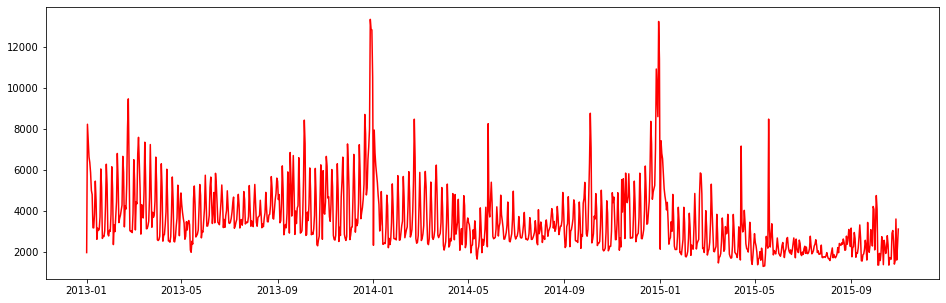

In [55]:
plt.figure(figsize=(16, 5))

plt.plot(sales_gr1.index, sales_gr1['item_cnt_day'], label='total', color='r')

## Виден явный тренд и сезонность 

<Figure size 1152x864 with 0 Axes>

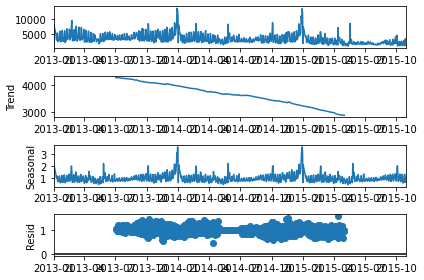

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sales_gr1, 
                            model='multiplicative',
                            period=365)
plt.figure(figsize=(16,12))
result.plot();

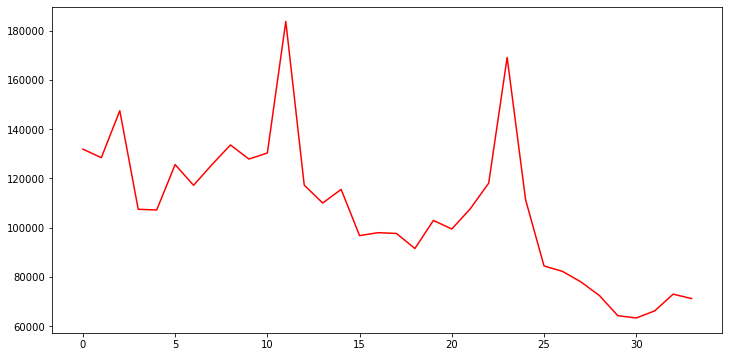

In [57]:
sales_gr3 = sales1.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(12, 6))
sales_gr3.astype("float")

plt.plot(sales_gr3['date_block_num'], sales_gr3['item_cnt_day'], label='total', color='r')